In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from collections import deque
%matplotlib inline

In [2]:
class Line():
    def __init__(self):
        self.__frame_num = 5
        self.detected = False
        #self.bestx = None
        self.best_fit = None
        #self.line_base_pos = None
        self.lane_inds = []
        self.allx = None
        self.ally = None
        self.radius_of_curvature = None
        #self.line_base_pos = None
        #self.bottom_x_pos = deque(maxlen=self.__frame_num)
        self.recent_xfitted = deque(maxlen=self.__frame_num)
        #self.A = deque(maxlen=self.__frame_num)
        #self.B = deque(maxlen=self.__frame_num)
        #self.C = deque(maxlen=self.__frame_num)

In [3]:
# Construct a function to undistort image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

In [4]:
def binary_transfor(img, l_thresh=(215, 255), b_thresh=(145, 200)):
    # Convert to HLS color space and separate the L channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #s_channel = hls[:,:,2]
    
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= 180) & (s_channel <= 255)] = 1
    
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= 220) & (r_channel <= 255)] = 1

    # Convert to HLS color space and separate the L channel
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
    l_channel = luv[:,:,0]
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    #r_channel = img[:,:,0]
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    b_channel = lab[:,:,2]
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(b_binary), sxbinary, s_binary)) * 255  
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(l_channel)
    # good 1 combined_binary[(l_binary == 1) | (b_binary == 1) ] = 1
    combined_binary[(l_binary == 1) | (b_binary == 1) ] = 1
    stacked_binary = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    return combined_binary, stacked_binary

In [5]:
# Construct a function to make perspective transform so that hte lines look
# straight from a bird's eye view, it returns perspective transform matrixs
def get_M(img):
    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates
    src = np.float32([[733, 477], [1110, 719], [226, 719],[559, 477]])
    # Four desired coordinates
    dst = np.float32([[1110, 50], [1110, 719], [226, 719],[226, 50]])
    
    # Compute the perspective transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse erspective transform matrix Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

In [6]:
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_image

In [7]:
# Define function to find the lane boundary
def blind_search(binary_warped, nwindows=9, margin=100, minpix=50, debug = False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwindows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #left_line.lane_inds = []
    #right_line.lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if debug:
            cv2.rectangle(img_with_window,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(img_with_window,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_line.lane_inds.append(good_left_inds)
        right_line.lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_line.lane_inds = np.concatenate(left_line.lane_inds)
    right_line.lane_inds = np.concatenate(right_line.lane_inds)
    #print(len(left_line.lane_inds))
    #print(len(right_line.lane_inds))

    if len(left_line.lane_inds) > 200 and len(right_line.lane_inds) > 200:
        # Extract left and right line pixel positions
        left_line.allx = nonzerox[left_line.lane_inds]
        left_line.ally = nonzeroy[left_line.lane_inds] 
        right_line.allx = nonzerox[right_line.lane_inds]
        right_line.ally = nonzeroy[right_line.lane_inds]
        left_line.detected = True
        right_line.detected = True
        
    else:
        left_line.detected = False
        right_line.detected = False
    
    left_line.lane_inds = []
    right_line.lane_inds = []

In [8]:
def quick_search(binary_warped, margin = 60):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_line.lane_inds = \
        ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + \
        left_line.best_fit[2] - margin)) & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + \
        left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin))) 
        
    right_line.lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + \
                            right_line.best_fit[2] - margin)) & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + \
                            right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)))  
    
    if len(left_line.lane_inds.nonzero()[0]) > 200 and len(right_line.lane_inds.nonzero()[0]) > 200:
        
        left_line.allx = nonzerox[left_line.lane_inds]
        left_line.ally = nonzeroy[left_line.lane_inds] 
        right_line.allx = nonzerox[right_line.lane_inds]
        right_line.ally = nonzeroy[right_line.lane_inds]
        left_line.detected = True
        right_line.detected = True
        
        #print(len(left_line.allx))
        #print(len(right_line.allx))
    else:
        left_line.detected = False
        right_line.detected = False
    
    left_line.lane_inds = []
    right_line.lane_inds = []

In [9]:
def cal_radius_and_caroff(binary_img_size, xm_per_pix, ym_per_pix):
    if left_line.detected == True:
        left_fit = np.polyfit(left_line.ally, left_line.allx, 2)
        right_fit = np.polyfit(right_line.ally, right_line.allx, 2)
        left_line.recent_xfitted.append(left_fit)
        right_line.recent_xfitted.append(right_fit)
        left_line.best_fit = np.mean(left_line.recent_xfitted, axis=0)
        right_line.best_fit = np.mean(right_line.recent_xfitted, axis=0)
        #print(left_fit)
        #print(right_fit)
              
        car_y_position = binary_img_size[0] - 1
        left_line_position = left_line.best_fit[0]*car_y_position**2 + left_line.best_fit[1]*car_y_position \
        + left_line.best_fit[2]
        right_line_position = right_line.best_fit[0]*car_y_position**2 + right_line.best_fit[1]*car_y_position \
        + right_line.best_fit[2]
        
        car_position = binary_img_size[1] // 2
        lane_center = left_line_position + (right_line_position - left_line_position)/2
        car_offset = (car_position - lane_center) * xm_per_pix
        
        y_eval_radius = car_y_position * ym_per_pix
        left_fit_cr = np.polyfit(left_line.ally * ym_per_pix, left_line.allx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(right_line.ally * ym_per_pix, right_line.ally * xm_per_pix, 2)
        
        left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval_radius + left_fit_cr[1])**2)**1.5) \
        / np.absolute(2*left_fit_cr[0])
        right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval_radius + right_fit_cr[1])**2)**1.5) \
        / np.absolute(2*right_fit_cr[0])

        return car_offset

In [10]:
def project_lines(undist2warp,  Minv, car_off, warp_zero):
    ploty = np.linspace(0, undist2warp.shape[0]-1, undist2warp.shape[0])
    
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = warp_zero
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist2warp.shape[1], undist2warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist2warp, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left radius: ' + str(round(left_line.radius_of_curvature, 1)) + 'm', (50,50), cv2.FONT_HERSHEY_COMPLEX,
                1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, 'Right radius: ' + str(round(right_line.radius_of_curvature, 1)) + 'm', (50,80), cv2.FONT_HERSHEY_COMPLEX,
                1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(result, 'Car is ' + str(round(car_off, 3)) + 'm right of center', (50, 110), cv2.FONT_HERSHEY_COMPLEX,
                1, (255,0,0), 2, cv2.LINE_AA)
    
    return result

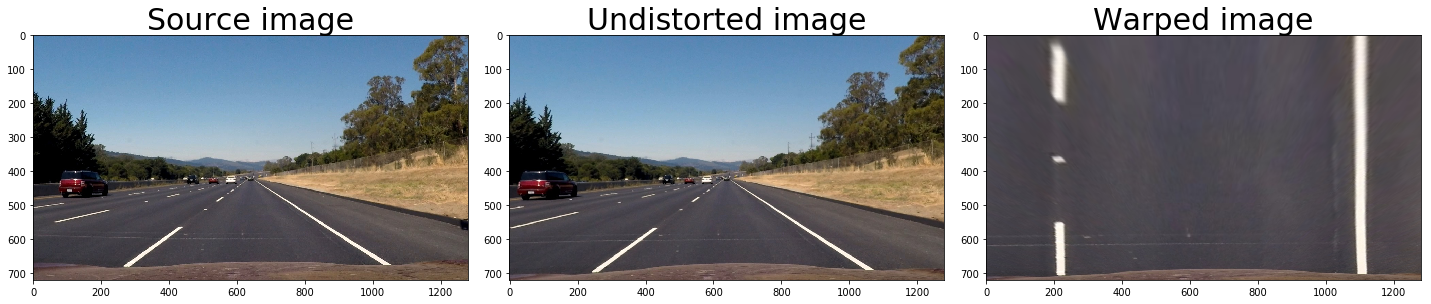

In [11]:
dist_pickle = pickle.load( open("camera_parameters.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

M_image2undist = mpimg.imread('test_images/straight_lines2.jpg')
origin_img_size = (M_image2undist.shape[0], M_image2undist.shape[1], M_image2undist.shape[2])
binary_img_size = (M_image2undist.shape[0], M_image2undist.shape[1])

# Undistort the image using function cal_undistort()
M_undist2warp = cal_undistort(M_image2undist, mtx, dist)
# Calculate the perspective transform matrix using function get_M()
perspective_M, Minv = get_M(M_undist2warp)
# Make perspective transform using function warp()
M_warped_image = warp(M_undist2warp, perspective_M)
warp_zero = np.zeros_like(M_image2undist[:,:,0])


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.tight_layout()
ax1.set_title('Source image', fontsize=30)
ax1.imshow(M_image2undist)
ax2.set_title('Undistorted image', fontsize=30)
ax2.imshow(M_undist2warp)
ax3.set_title('Warped image', fontsize=30)
ax3.imshow(M_warped_image)

In [12]:
def get_const_information():
    dist_pickle = pickle.load( open("camera_parameters.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    M_image2undist = mpimg.imread('test_images/straight_lines2.jpg')
    origin_img_size = (M_image2undist.shape[0], M_image2undist.shape[1], M_image2undist.shape[2])
    binary_img_size = (M_image2undist.shape[0], M_image2undist.shape[1])
    
    # Undistort the image using function cal_undistort()
    M_undist2warp = cal_undistort(M_image2undist, mtx, dist)
    # Calculate the perspective transform matrix using function get_M()
    perspective_M, Minv = get_M(M_undist2warp)
    # Make perspective transform using function warp()
    M_warped_image = warp(M_undist2warp, perspective_M)
    warp_zero = np.zeros_like(M_image2undist[:,:,0])
    
    return mtx, dist, binary_img_size, warp_zero, perspective_M, Minv

In [13]:
mtx, dist, binary_img_size, warp_zero, M, Minv = get_const_information()
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [14]:
left_line = Line()
right_line = Line()

In [15]:
def process_image(image):
    image_cpy = np.copy(image)
    undist2warp = cal_undistort(image, mtx, dist)
    binary_undist, stacked_binary = binary_transfor(undist2warp)
    binary_warped = warp(binary_undist, M)
    if left_line.detected:
        quick_search(binary_warped)
    else:
        blind_search(binary_warped)
    if left_line.detected:
        car_offset = cal_radius_and_caroff(binary_img_size, xm_per_pix, ym_per_pix)
        result_img = project_lines(undist2warp, Minv, car_offset, warp_zero)
        return result_img
    else:
        return image_cpy

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
white_output = 'output_videos/project_video_output2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output2.mp4
[MoviePy] Writing video output_videos/project_video_output2.mp4


100%|█████████▉| 1260/1261 [02:43<00:00,  8.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output2.mp4 

CPU times: user 3min 15s, sys: 15.1 s, total: 3min 30s
Wall time: 2min 44s


In [66]:
left_line.detected = False
right_line.detected = False

In [65]:
white_output = 'output_videos/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:55<00:00,  9.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

CPU times: user 1min 8s, sys: 5.9 s, total: 1min 13s
Wall time: 56.5 s


In [119]:
image = mpimg.imread('test_images/test5.jpg')
undist2warp = cal_undistort(image, mtx, dist)
binary_undist, stacked_binary = binary_transfor(undist2warp)
binary_warped = warp(binary_undist, M)

In [120]:
if left_line.detected:
    quick_search(binary_warped)
else:
    blind_search(binary_warped)

23074
5543
True


In [121]:
print(left_line.detected)

True


In [122]:
car_offset = cal_radius_and_caroff(binary_img_size, xm_per_pix, ym_per_pix)

[ 2.30499016e-04 -3.85397445e-01  4.48002120e+02]
[ 3.83722642e-04 -5.09942139e-01  1.20390280e+03]


In [123]:
print(left_line.detected)

True


In [124]:
if left_line.detected:
    quick_search(binary_warped)
else:
    blind_search(binary_warped)

23125
5796


In [125]:
car_offset = cal_radius_and_caroff(binary_img_size, xm_per_pix, ym_per_pix)

[ 2.30549052e-04 -3.86164554e-01  4.48428143e+02]
[ 3.81410101e-04 -5.09635907e-01  1.20458641e+03]


In [127]:
result_img = project_lines(undist2warp, Minv, car_offset, warp_zero)

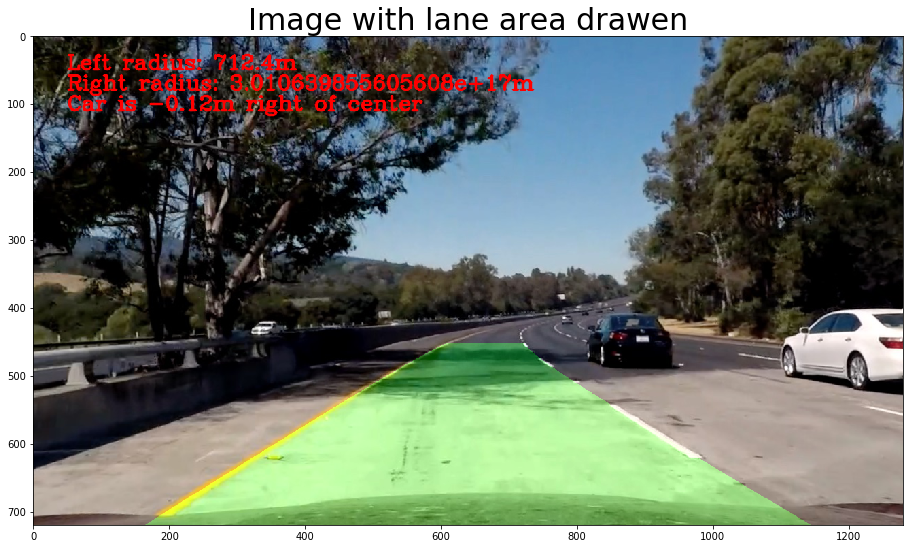

In [128]:
fig = plt.figure(1, figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.set_title('Image with lane area drawen', fontsize=30)
plt.imshow(result_img)

In [113]:
print(warp_zero.shape)

(720, 1280)
